In [1]:
%matplotlib inline
from datacube import Datacube
import datacube

In [2]:
import numpy as np

In [3]:
dc = Datacube()

# Load Sentinel-1 data

In [4]:
query = {
'y': (-35.217575569215505, -34.97543887925878), 
'x': (149.2719268798828, 149.5095062255859),
'time':('2017-01-01','2018-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (30, -30)
}

In [5]:
dss = dc.find_datasets(product='s1_gamma0_geotif_scene', **query)
len(dss)

86

In [6]:
radar = dc.load(product='s1_gamma0_geotif_scene', **query)

# select scenes covering lake George

In [7]:
total_px=len(radar.x)*len(radar.y)

In [8]:
valid=radar.where(radar.vv!=0).where(radar.vh!=0).count(dim=('x','y'))

In [9]:
good=(valid.vh/total_px)>0.5
good.sum()

<xarray.DataArray 'vh' ()>
array(27)

In [10]:
radar_lake = radar.sel(time=good)

In [11]:
radar_lake_clean = radar_lake.where(radar_lake!=0)

In [12]:
smoothed = radar_lake_clean.rolling(x=3).mean().rolling(y=3).mean()

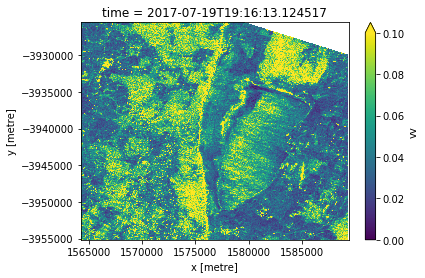

In [13]:
smoothed.isel(time=14).vv.plot(vmin=0,vmax=0.1)

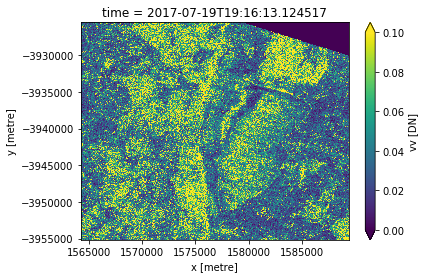

In [14]:
radar_lake.isel(time=14).vv.plot(vmin=0,vmax=0.1)

# replace 0 with nan and negative with a small value

In [15]:
clean=smoothed.copy()
clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
clean=clean.where(clean<1000)

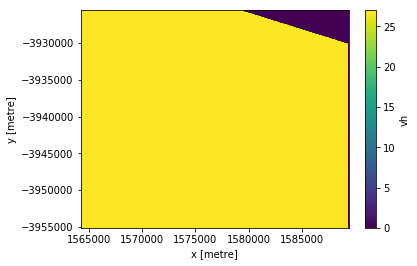

In [16]:
clean.vh.count(dim='time').plot()

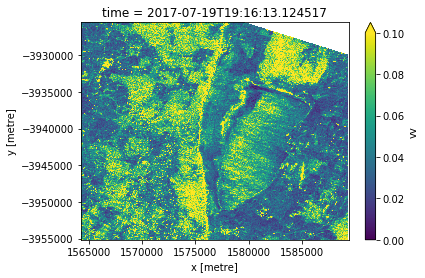

In [17]:
clean.isel(time=14).vv.plot(vmin=0,vmax=0.1)

# convert to dB

In [18]:
d_clean=10*np.log10(clean)

# add vv+vh

In [19]:
clean['vv_plus_vh']=clean.vh+clean.vv
clean['vh_over_vv']=clean.vh/clean.vv
d_clean['vh_minus_vv'] = d_clean.vh - d_clean.vv

In [20]:
clean, d_clean

(<xarray.Dataset>
 Dimensions:     (time: 27, x: 836, y: 988)
 Coordinates:
   * time        (time) datetime64[ns] 2017-01-08T19:16:07.759542 ...
   * y           (y) float64 -3.955e+06 -3.955e+06 -3.955e+06 -3.955e+06 ...
   * x           (x) float64 1.589e+06 1.589e+06 1.589e+06 1.589e+06 ...
 Data variables:
     vh          (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
     vv          (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
     vv_plus_vh  (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
     vh_over_vv  (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...,
 <xarray.Dataset>
 Dimensions:      (time: 27, x: 836, y: 988)
 Coordinates:
   * time         (time) datetime64[ns] 2017-01-08T19:16:07.759542 ...
   * y            (y) float64 -3.955e+06 -3.955e+06 -3.955e+06 -3.955e+06 ...
   * x            (x) float64 1.589e+06 1.589e+06 1.589e+06 1.589e+06 ...
 Data variables:
     vh           (time, y, x) float32 na

# check separation of water and nonwater over time

for vv, vh, vv+vh

In [21]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

In [22]:
import numpy as np
from scipy.signal import argrelextrema

#x = np.random.random(12)

# for local maxima
#argrelextrema(x, np.greater)

# for local minima
#argrelextrema(x, np.less)


0 vv 0.010099999999999998
1 vv 0.025399999999999992
2 vv 0.011899999999999997
3 vv 0.0191
4 vv 0.010999999999999998
5 vv 0.025399999999999992
6 vv 0.016399999999999998
7 vv 0.012799999999999997
8 vv 0.0191
9 vv 0.010099999999999998
10 vv 0.014599999999999997
11 vv 0.010999999999999998
12 vh 0.015
13 vv 0.025399999999999992
14 vh_over_vv 0.1
15 vv 0.021799999999999993
16 vv 0.014599999999999997
17 vv 0.014599999999999997
18 vh_over_vv 0.08
19 vv 0.009199999999999998
20 vh_over_vv 0.08
21 vv 0.012799999999999997
22 vv 0.012799999999999997
23 vv 0.019999999999999997
24 vv 0.013699999999999997
25 vv 0.012799999999999997
26 vv 0.010999999999999998


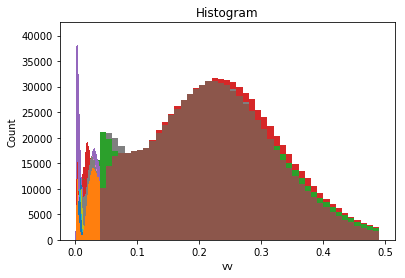

In [23]:
water=np.zeros_like(clean.vv)
for i in range(27):
    hist, hist_x, t=clean.vv.isel(time=i).plot.hist(bins=np.arange(0.002,0.04,0.0009))
    minima= hist_x[argrelextrema(hist, np.less)]
    maxima= hist_x[argrelextrema(hist, np.greater)]
    found =False
    if len(minima)> 0 and maxima[0]< minima[0] and minima.max()>0.008:
        minima=minima[minima>0.008]
        m=np.abs(minima-0.012).argmin()
        if minima[m]<0.3:
            print(i,'vv',minima[m])
            found=True
            water[i,:,:]=clean.vv.isel(time=i)<minima[m]
    if not found:
        hist, hist_x, t=clean.vh_over_vv.isel(time=i).plot.hist(bins=np.arange(0,0.5,0.01))
        minima= hist_x[argrelextrema(hist, np.less)]
        maxima= hist_x[argrelextrema(hist, np.greater)]
        if len(minima)> 0 and maxima[0]< minima[0]:
            m=np.abs(minima-0.012).argmin()
            if minima[0]<0.3:
                print(i,'vh_over_vv',minima[m])
                found=True
                water[i,:,:]=clean.vh_over_vv.isel(time=i)<minima[m]
    if not found:
        hist, hist_x, t=clean.vh.isel(time=i).plot.hist(bins=np.arange(0.00,0.04,0.0005))
        minima= hist_x[argrelextrema(hist, np.less)]
        maxima= hist_x[argrelextrema(hist, np.greater)]
        if len(minima)> 0 and maxima[0]< minima[0]:
            m=np.abs(minima-0.012).argmin()
            if minima[0]<0.3:
                print(i,'vh',minima[m])
                found=True
                water[i,:,:]=clean.vv.isel(time=i)<minima[m]


In [24]:
clean['wofs'] = ('time','y','x'), water

In [25]:
clean['wofs'] = clean.wofs.where(~clean.vh.isnull()).where(~clean.vv.isnull())
clean

<xarray.Dataset>
Dimensions:     (time: 27, x: 836, y: 988)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-08T19:16:07.759542 ...
  * y           (y) float64 -3.955e+06 -3.955e+06 -3.955e+06 -3.955e+06 ...
  * x           (x) float64 1.589e+06 1.589e+06 1.589e+06 1.589e+06 ...
Data variables:
    vh          (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    vv          (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    vv_plus_vh  (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    vh_over_vv  (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    wofs        (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...

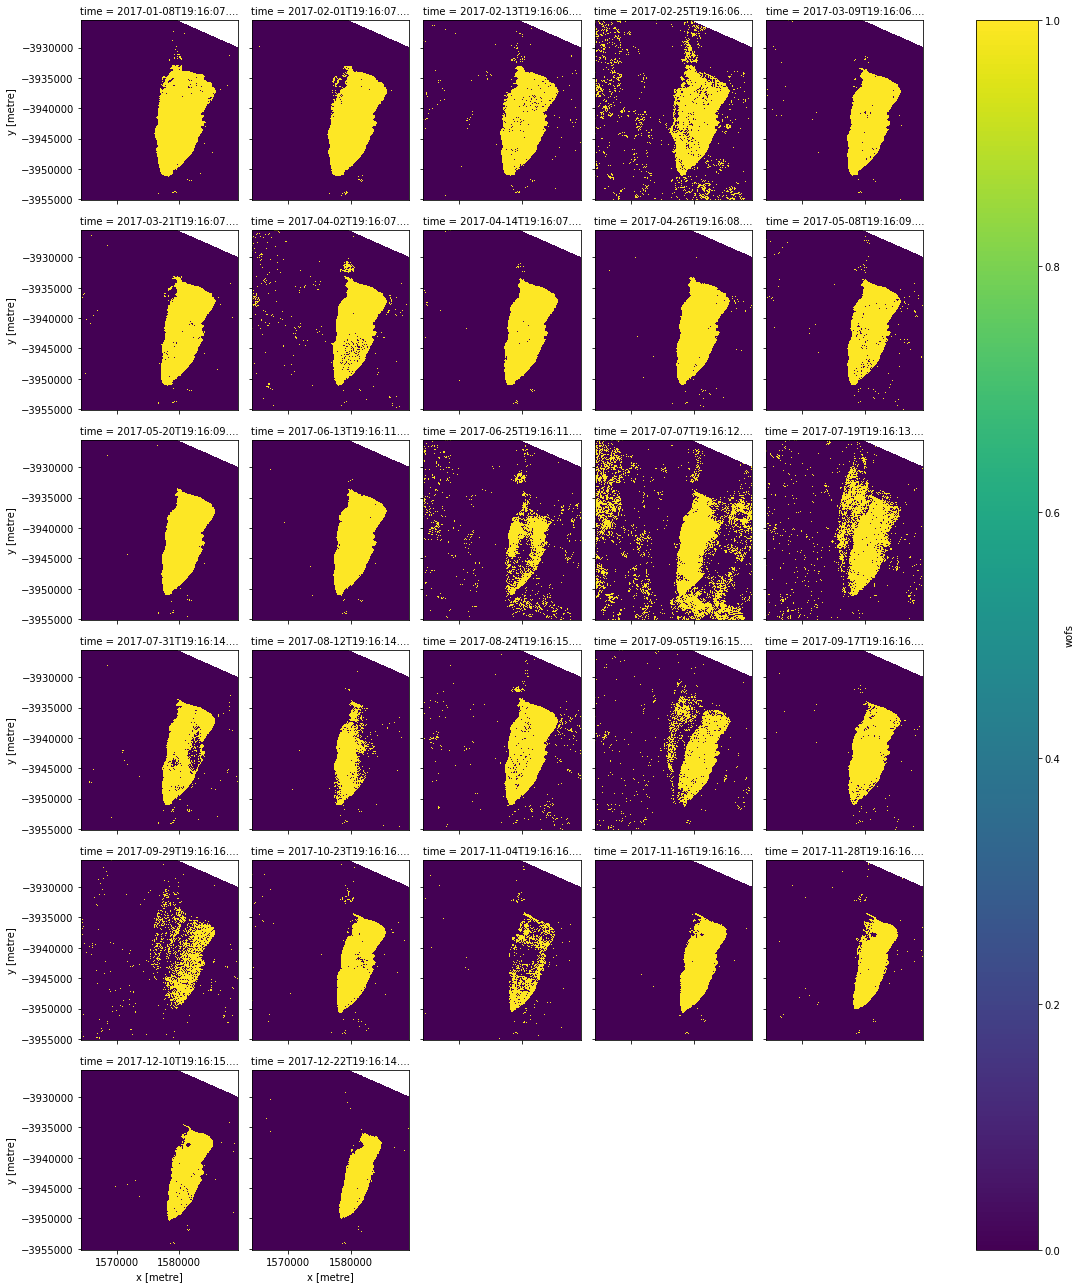

In [26]:
clean.wofs.plot(col='time',col_wrap=5)

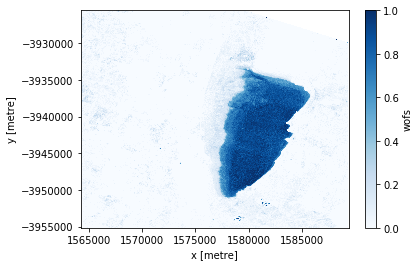

In [27]:
clean.wofs.mean(dim='time').plot(cmap='Blues')

In [28]:
water=clean.wofs.to_dataset('wofs')
dataset_to_output =  water.assign_attrs(radar.attrs)
datacube.storage.storage.write_dataset_to_netcdf(dataset_to_output, 's1_water_hist.nc')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  """Entry point for launching an IPython kernel.


In [29]:
wofs=dc.load(product='wofs_annual_summary', **query)

In [30]:
#wofs_all_query= query.copy()
#wofs_all_query['time']=('2000-01-01','2018-01-01')
#wofs_all=dc.load(product='wofs_annual_summary', **wofs_all_query)
#wofs_any=wofs_all.max(dim='time').frequency

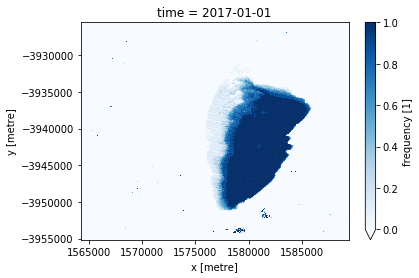

In [31]:
wofs.isel(time=0).frequency.plot(cmap='Blues', vmin=0, vmax=1)

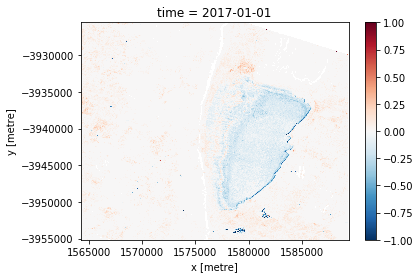

In [32]:
wofs_freq=wofs.isel(time=0).frequency
wofs_freq=wofs_freq.where(wofs_freq>=0)
(clean.wofs.mean(dim='time')-wofs_freq).plot()

In [33]:
from rasterio import features
from shapely.geometry import shape

def find_largest_water(wofs):
    max_water = 0
    for fshape, value in features.shapes((wofs>0).values.astype('int16'), mask=(wofs>0).values):
        geom=shape(fshape)
        if geom.area>max_water:
            max_water = geom.area
            water_body = geom
    return water_body

lake = find_largest_water(wofs.frequency)

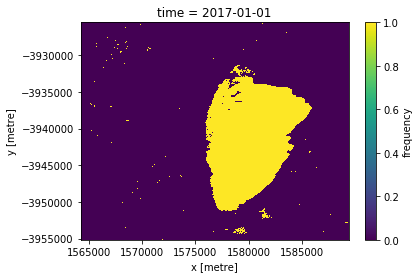

In [34]:
(wofs.frequency>0.).plot()

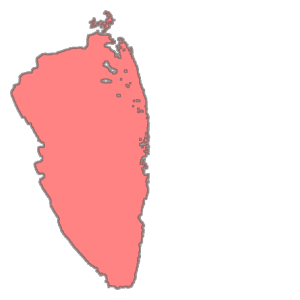

In [35]:
lake